# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

**Assignment**
Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
   * Excel and Vensim are only supported on Windows
   * Vensim requires the DSS version of Vensim
   * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get it from [NetLogo 6.1.1](https://ccl.northwestern.edu/netlogo/download.shtml)
   * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
   * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).
    

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes [example scripts](https://github.com/quaquel/EMAworkbench/tree/master/ema_workbench/examples) for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel).
  * This [tutorial](https://emaworkbench.readthedocs.io/en/latest/basic_tutorial.html) also shows a simple model in Python, Vensim and Excel connected to the workbench.

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function. 

In [1]:
# Some imports you may need
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging)

from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel

from ema_workbench import Samplers

from ema_workbench.analysis.plotting import lines, Density

C:\Users\Ewout\AppData\Local\Programs\Python\Python311\Lib\site-packages\ema_workbench\connectors\__init__.py:19: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)
C:\Users\Ewout\AppData\Local\Programs\Python\Python311\Lib\site-packages\ema_workbench\connectors\__init__.py:34: ImportWarning: simio connector not available
  warnings.warn("simio connector not available", ImportWarning)
C:\Users\Ewout\AppData\Local\Programs\Python\Python311\Lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive " "inspection not available"), ImportWarning)


the code given above returs a 2D array of shape (reps, timesteps). This means that the outcomes over a series of experiments will become 3D (n_experiments, n_reps, timesteps). Since replication is 1 in this case, we want to get rid of the middle dimension. There are various ways to do this. The easiest given the code above is to use a function as an optional keyword argument on the outcome class to do this. The ```np.squeeze``` function does exactly this.

A more elegant solution would be to remove reps as an argument in the above code and use SingleReplicationNetLogoModel.

In [2]:
# Import the Python function
from model.pred_prey import PredPrey

In [3]:
# Add as a system variable
import os
os.environ["JAVA_HOME"] = 'C:/Program Files/NetLogo 6.3.0/runtime/bin/server/'

In [ ]:
ema_logging.log_to_stderr(ema_logging.INFO)

#We can define common uncertainties and outcomes for each model:
uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                 RealParameter('predation_rate', 0.0005, 0.003),
                 RealParameter('predator_efficiency', 0.001, 0.004),
                 RealParameter('predator_loss_rate', 0.04, 0.08)] 

outcomes = [TimeSeriesOutcome('TIME', function=np.squeeze),
            TimeSeriesOutcome('predators', function=np.squeeze),
            TimeSeriesOutcome('prey', function=np.squeeze)]


#Define the Python model
py_model = Model('Python', function=PredPrey)
py_model.uncertainties = uncertainties
py_model.outcomes = outcomes

#Define the NetLogo model
nl_model = NetLogoModel('NetLogo', wd='./model/', model_file="PredPrey.nlogo")
nl_model.run_length = int(365 / 0.25)
nl_model.replications = 1
nl_model.uncertainties = uncertainties
nl_model.outcomes = outcomes

#Define the Excel model
excel_model = ExcelModel('Excel', wd='./model/', model_file='PredPrey.xlsx')
excel_model.default_sheet = 'Sheet1'
excel_model.uncertainties = uncertainties
excel_model.outcomes = outcomes

#Define the PySD (Vensim) model
pysd_model = PysdModel('PySD', mdl_file='./model/PredPrey.mdl')
pysd_model.uncertainties = uncertainties
pysd_model.outcomes = outcomes
    
nr_experiments = 50

#Using Latin Hypercube sampling
experiments, outcomes = perform_experiments([py_model, nl_model, excel_model, pysd_model],
                                  nr_experiments, uncertainty_sampling=Samplers.LHS)


 75%|██████████████████████████████          | 150/200 [00:48<00:44,  1.11it/s][MainProcess/ERROR] 'TIME not found as model element'
Traceback (most recent call last):
  File "C:\Users\Ewout\AppData\Local\Programs\Python\Python311\Lib\site-packages\ema_workbench\em_framework\experiment_runner.py", line 91, in run_experiment
    model.run_model(scenario, policy)
  File "C:\Users\Ewout\AppData\Local\Programs\Python\Python311\Lib\site-packages\ema_workbench\util\ema_logging.py", line 152, in wrapper
    res = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ewout\AppData\Local\Programs\Python\Python311\Lib\site-packages\ema_workbench\em_framework\model.py", line 339, in run_model
    outputs = self.run_experiment(experiment)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ewout\AppData\Local\Programs\Python\Python311\Lib\site-packages\ema_workbench\util\ema_logging.py", line 152, in wrapper
    res = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^

EMAError: exception in run_model
Caused by: KeyError: 'TIME not found as model element'

We can split the results tuple into experiments and outcomes, and check the dimensions of each. The dimensions of each outcome array correspond to 200 experiments (50 unique combinations of uncertainties * 4 models), 1 replication, and 1461 time steps (or 365/0.25).

In [10]:
print(experiments.shape)
print(outcomes['prey'].shape)

#The experiments are grouped sequentially by model: indices 0-49 are the Python function, 50-99 the NetLogo model, etc.
experiments.iloc[[0, 50, 100, 150], :]

(150, 7)
(150, 1461)


,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario,policy,model
0,0.001661,0.001061,0.047008,0.017603,0,None,Python
50,0.001661,0.001061,0.047008,0.017603,0,None,NetLogo
100,0.001661,0.001061,0.047008,0.017603,0,None,Excel


The lines graph shows that although the models behave quite differently depending on the experiments, the results are graphically identical across the 4 models.

In [11]:
for k, v in outcomes.items():
    print(k, v.shape)

TIME (150, 1461)
predators (150, 1461)
prey (150, 1461)


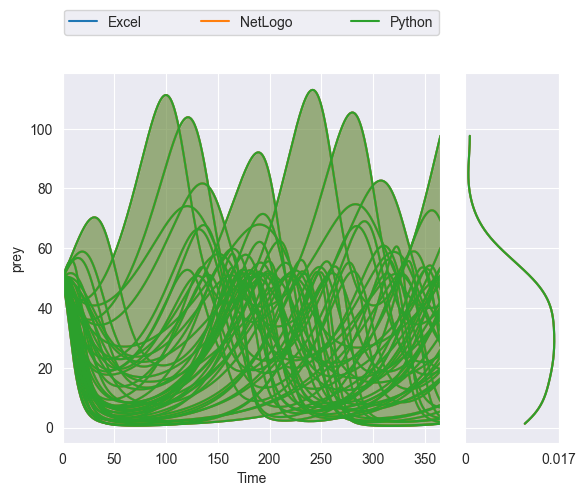

In [12]:
experiments_to_show = np.arange(0, experiments.shape[0], 1)

lines(experiments, outcomes, outcomes_to_show='prey', group_by='model',
      show_envelope=True, density=Density.KDE, titles=None, 
      experiments_to_show=experiments_to_show)
plt.show()

Finally, we can check any differences between the model implementations and the Python function, by using logical indexing to select the outcome indices corresponding to each model, and subtracting the arrays from each other:

In [13]:
#Find the model implementations that were sampled in the experiments
models = [i for i in experiments.model.unique() if i != 'Python']

for model in models:
    logical = experiments.model==model
    
    print('Max absolute error with {}:'.format(model))
    print(np.max(abs(outcomes['prey'][logical] - outcomes['prey'][logical])))

Max absolute error with NetLogo:
0.0
Max absolute error with Excel:
0.0
